# Feature Selection and Classification using Random Forest and HAC

In this notebook, the 24-hour flight data is used to conduct the classification.

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score
from scipy.cluster.hierarchy import ward, fcluster
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.preprocessing import RobustScaler

In [245]:
%run "../flight phase on dataset/db.py"
df = db_to_pandas(filename='testDB2.db')
#df.dropna(inplace=True)
df.drop(columns=['icao'],inplace=True)

In [278]:
df = pd.read_csv('descriptors.csv').drop(columns=['icao','icao_airline'])

In [374]:
df[df['airline'].isna()]

,flight_id,airline,duration_descent,avg_speed_descent,std_speed_descent,avg_vertrate_speed_descent,std_vertrate_speed_descent,max_spd_descent,min_spd_descent,max_vertrate_speed_descent,...,duration_climb,avg_speed_climb,std_speed_climb,avg_vertrate_speed_climb,std_vertrate_speed_climb,max_spd_climb,min_spd_climb,max_vertrate_speed_climb,min_vertrate_speed_climb,airline_cat
14,15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1
132,133,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1400.0,204.332157,35.422354,7.968039,3.205466,236.48,104.51,17.56,3.90,-1
151,152,NaN,1720.0,185.456375,73.529461,-6.393500,3.852681,283.22,63.26,1.63,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1
227,228,NaN,2150.0,164.249238,80.861274,-5.654857,3.520464,296.90,52.97,0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1
232,233,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1061.0,206.396863,40.120096,9.657843,4.611813,241.81,78.74,21.13,0.00,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14666,4705,NaN,1720.0,163.239770,80.793064,-6.734253,3.969761,296.80,69.88,0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1
14668,4707,NaN,1859.0,178.947326,65.532168,-6.862442,3.979940,258.11,81.75,0.33,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1
14674,4713,NaN,1600.0,168.567564,54.453090,-7.095000,4.877655,241.17,72.49,0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1
14885,4924,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1240.0,205.680317,48.202400,9.846667,4.727823,255.26,80.36,22.11,0.33,-1


In [372]:
df['airline'].value_counts()

American Airlines       2150
Delta Air Lines         1164
LATAM Brasil             825
United Airlines          695
JetBlue Airways          665
                        ... 
Atlantic Airways           1
Sky Wings Airlines         1
Airbus Industrie           1
AirAsia Japan              1
Syrian Arab Airlines       1
Name: airline, Length: 163, dtype: int64

In [281]:
# Here categorical codes are added in the dataframe for airlines
df["airline"] = df["airline"].astype('category')
df["airline_cat"]=df["airline"].cat.codes
df_noairline = df.drop(columns=['airline'])
df_noairline.set_index('flight_id',inplace=True)
df_noairline.head()

,duration_descent,avg_speed_descent,std_speed_descent,avg_vertrate_speed_descent,std_vertrate_speed_descent,max_spd_descent,min_spd_descent,max_vertrate_speed_descent,min_vertrate_speed_descent,duration_cruise,...,duration_climb,avg_speed_climb,std_speed_climb,avg_vertrate_speed_climb,std_vertrate_speed_climb,max_spd_climb,min_spd_climb,max_vertrate_speed_climb,min_vertrate_speed_climb,airline_cat
flight_id,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1120.0,167.463860,29.203683,9.930351,5.284945,213.68,83.07,23.41,0.65,37
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,940.0,200.185000,27.145622,9.664375,4.765878,234.28,126.93,22.76,-0.33,132
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10410.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,143
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,810.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,127
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1360.0,...,1000.0,195.157255,44.359372,10.531373,3.977624,235.11,69.63,19.18,4.23,113


In [282]:
# The dictionary of airline and their codes
airlines_decoder = dict(enumerate(df["airline"].cat.categories))

<div class="alert alert-block alert-warning">
<b>Hypothesis:</b> Only airlines with 10 logs or more are eligible for classification. So others will be excluded in the following analysis procedure.
</div>

In [283]:
filt_10log = df_noairline['airline_cat'].value_counts()>=25

In [284]:
airline_list_cat = filt_10log[filt_10log.values==True].index

In [285]:
df_filt_10log = df_noairline[df_noairline['airline_cat'].isin(airline_list_cat)]

# Correlation between features

<AxesSubplot:>

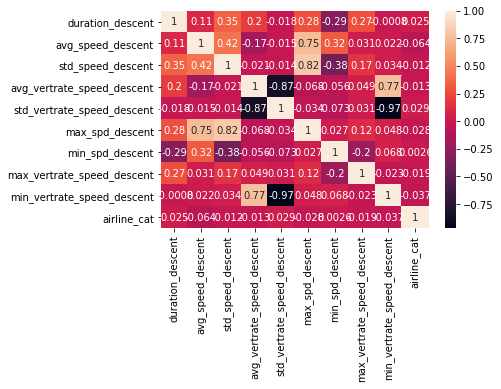

In [268]:
descent = ['duration_descent','avg_speed_descent','std_speed_descent','avg_vertrate_speed_descent','std_vertrate_speed_descent', 'max_spd_descent',
       'min_spd_descent', 'max_vertrate_speed_descent',
       'min_vertrate_speed_descent','airline_cat']
sns.heatmap(df_noairline[descent].corr(),annot = True)

In [129]:
cruise = ['duration_cruise', 'avg_speed_cruise',
       'std_speed_cruise', 'avg_vertrate_speed_cruise',
       'std_vertrate_speed_cruise', 'delta_h_cruise', 'max_spd_cruise',
       'min_spd_cruise', 'max_vertrate_speed_cruise',
       'min_vertrate_speed_cruise', 'mean_altitude_cruise',
       'std_altitude_cruise','airline_cat']
sns.heatmap(df_noairline[cruise].corr(),annot = True)

KeyError: "['duration_cruise', 'delta_h_cruise'] not in index"

In [130]:
climb = ['duration_climb', 'avg_speed_climb',
       'std_speed_climb', 'avg_vertrate_speed_climb',
       'std_vertrate_speed_climb', 'delta_h_climb', 'max_spd_climb',
       'min_spd_climb', 'max_vertrate_speed_climb', 'min_vertrate_speed_climb',
       'airline_cat']
sns.heatmap(df_noairline[climb].corr(),annot = True)

KeyError: "['delta_h_climb', 'duration_climb'] not in index"

In [12]:
corr_matrix = df_noairline.corr(method='spearman')

In [13]:
(corr_matrix[(corr_matrix>0.5) | (corr_matrix<-0.5)].count().sum() - corr_matrix.columns.shape[0])/2

37.0

There exists several couples (37) of variables that are highly correlated, with a coefficient of correlation superior to 0.5. A feature selection process needs to be conducted.

In [287]:
# Standard Scaling (not necessary for random forest)
X = df_filt_10log.iloc[:,:-1]
y = df_filt_10log.loc[:,["airline_cat"]]
scaler = preprocessing.StandardScaler().fit(X)
X_scaled = scaler.transform(X)

In [327]:
# Spliting the data into train and test datasets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [332]:
# Training a random forest classifier 
clf = DecisionTreeClassifier(criterion='entropy')#n_estimators=10000, random_state=0, n_jobs=-1)
clf.fit(X_train, y_train)

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

In [330]:
from sklearn.tree import DecisionTreeClassifier

In [21]:
# Print the name and gini importance of each feature
columns = df_filt_10log.columns
for feature in zip(columns, clf.feature_importances_):
    print(feature)

('flight_duration', 0.0414246887612151)
('duration_descent', 0.03445559171330998)
('avg_speed_descent', 0.02949673787239679)
('std_speed_descent', 0.031172277598213678)
('avg_vertrate_speed_descent', 0.035222605308581116)
('std_vertrate_speed_descent', 0.03337192166642727)
('delta_h_descent', 0.03436829777570008)
('max_spd_descent', 0.0280538891011951)
('min_spd_descent', 0.03495551642310457)
('max_vertrate_speed_descent', 0.01799158460835214)
('min_vertrate_speed_descent', 0.029416579394468186)
('duration_cruise', 0.03582164573661657)
('avg_speed_cruise', 0.03225865193065493)
('std_speed_cruise', 0.030463346818096218)
('avg_vertrate_speed_cruise', 0.02945574650257564)
('std_vertrate_speed_cruise', 0.02840173565766762)
('delta_h_cruise', 0.024430047617873752)
('max_spd_cruise', 0.03036154485568474)
('min_spd_cruise', 0.029889018356510404)
('max_vertrate_speed_cruise', 0.016919292434589558)
('min_vertrate_speed_cruise', 0.016476424758751485)
('mean_altitude_cruise', 0.03334186448397551)

In [24]:
# Create a selector object that will use the random forest classifier to identify
# features that have an importance of more than 0.15

sfm = SelectFromModel(clf, threshold=0.025)

# Train the selector
sfm.fit(X_train, y_train)

NameError: name 'clf' is not defined

In [23]:
# Print the names of the most important features
i = 0
for feature_list_index in sfm.get_support(indices=True):
    print(columns[feature_list_index])
    i += 1
print(f'The number of columns chosen is {i}')

flight_duration
duration_descent
avg_speed_descent
std_speed_descent
avg_vertrate_speed_descent
std_vertrate_speed_descent
delta_h_descent
max_spd_descent
min_spd_descent
min_vertrate_speed_descent
duration_cruise
avg_speed_cruise
std_speed_cruise
avg_vertrate_speed_cruise
std_vertrate_speed_cruise
max_spd_cruise
min_spd_cruise
mean_altitude_cruise
std_altitude_cruise
duration_climb
avg_speed_climb
std_speed_climb
avg_vertrate_speed_climb
std_vertrate_speed_climb
delta_h_climb
max_spd_climb
min_spd_climb
max_vertrate_speed_climb
The number of columns chosen is 28


In [24]:
# Transform the data to create a new dataset containing only the most important features
# Note: We have to apply the transform to both the training X and test X data.
X_important_train = sfm.transform(X_train)
X_important_test = sfm.transform(X_test)

In [25]:
# Create a new random forest classifier for the most important features
clf_important = RandomForestClassifier(n_estimators=10000, random_state=0, n_jobs=-1)

# Train the new classifier on the new dataset containing the most important features
clf_important.fit(X_important_train, y_train)

<ipython-input-25-2862a864be5a>:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf_important.fit(X_important_train, y_train)


RandomForestClassifier(n_estimators=10000, n_jobs=-1, random_state=0)

In [26]:
# Apply The Full Featured Classifier To The Test Data
y_pred = clf.predict(X_test)

# View The Accuracy Of Our Full Feature Model
accuracy_score(y_test, y_pred)

0.33890214797136037

In [27]:
# Apply The Full Featured Classifier To The Test Data
y_important_pred = clf_important.predict(X_important_test)

# View The Accuracy Of Our Limited Feature Model
accuracy_score(y_test, y_important_pred)

0.3412887828162291

In [19]:
# Transform all data
selection = sfm.get_support()
X_columns = columns[:-1]
columns_remained = X_columns[selection]
X_new = sfm.transform(X)

NameError: name 'sfm' is not defined

In [289]:
columns_remained = ['duration_descent', 'avg_speed_descent',
       'std_speed_descent', 'avg_vertrate_speed_descent',
       'std_vertrate_speed_descent', 'delta_h_descent', 'max_spd_descent',
       'min_spd_descent', 'min_vertrate_speed_descent', 'duration_cruise',
       'avg_speed_cruise', 'std_speed_cruise', 'avg_vertrate_speed_cruise',
       'std_vertrate_speed_cruise', 'max_spd_cruise', 'min_spd_cruise',
       'mean_altitude_cruise', 'std_altitude_cruise', 'duration_climb',
       'avg_speed_climb', 'std_speed_climb', 'avg_vertrate_speed_climb',
       'std_vertrate_speed_climb', 'delta_h_climb', 'max_spd_climb',
       'min_spd_climb', 'max_vertrate_speed_climb']

# Aggregating data

In [300]:
df_new = pd.DataFrame(data = X)#[columns_remained], columns = columns_remained)
y.reset_index(inplace = True)

In [301]:
df_new = df_filt_10log.iloc[:,:-1]
y = df_filt_10log.loc[:,["airline_cat"]].reset_index()

In [302]:
df_new_scaled = pd.DataFrame(data = preprocessing.StandardScaler().fit_transform(df_new), columns = X.columns)

In [303]:
df_new_cat = pd.merge(df_new, y, how = 'left', left_index = True, right_on = 'flight_id')

In [304]:
df_new_scaled_cat = pd.merge(df_new_scaled, y, how = 'left', left_index = True, right_on = 'flight_id')

In [305]:
df_median_scaled = df_new_scaled_cat.groupby(by = 'airline_cat').median()
df_median = df_new_cat.groupby(by = 'airline_cat').median()

In [306]:
df_median_scaled.drop("flight_id", axis = 1, inplace=True)
df_median.drop("flight_id", axis = 1, inplace=True)

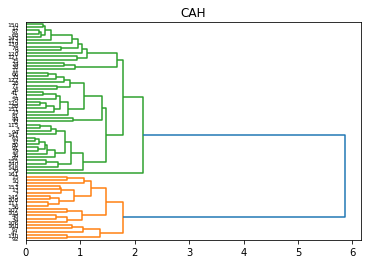

In [360]:
Z = linkage(df_median_scaled.drop(['duration_descent','duration_cruise','duration_climb'],axis=1),method='ward',metric='euclidean')
threshold = 2.5
plt.title('CAH')
dendrogram(Z,labels=df_median.index,orientation='right',color_threshold=threshold)
plt.show()

In [361]:
import numpy as np
import pandas
groupes_cah = fcluster(Z,t=threshold,criterion='distance')
print(groupes_cah)

[2 1 2 1 2 1 2 1 1 2 2 2 2 2 2 2 1 2 2 2 2 2 1 1 2 1 2 2 1 2 2 2 2 2 2 2 2
 2 2 2 1 2 2 1 1 1 1 1 2 2 2 2 2 2 1 2 2 2 1 2 2 2 2 1 2 1 2]


In [310]:
df_median['group'] = groupes_cah
df_median_scaled['group'] = groupes_cah

In [206]:
avgcol = ['flight_duration','duration_descent','mean_altitude_cruise','avg_speed_climb','avg_speed_cruise','avg_speed_descent']

In [207]:
for c in columns_remained:
    if 'duration' in c:
        print(df_median.groupby('group').mean()[c])

KeyError: 'flight_duration'

In [311]:
df_median.groupby('group').mean()#[avgcol]

,duration_descent,avg_speed_descent,std_speed_descent,avg_vertrate_speed_descent,std_vertrate_speed_descent,max_spd_descent,min_spd_descent,max_vertrate_speed_descent,min_vertrate_speed_descent,duration_cruise,...,std_altitude_cruise,duration_climb,avg_speed_climb,std_speed_climb,avg_vertrate_speed_climb,std_vertrate_speed_climb,max_spd_climb,min_spd_climb,max_vertrate_speed_climb,min_vertrate_speed_climb
group,,,,,,,,,,,,,,,,,,,,,
1,1603.750000,157.918089,53.891520,-6.915972,3.751047,230.184750,67.360250,0.000000,-16.055250,1921.725000,...,9.620953,1157.825000,193.458572,42.883995,9.150162,4.151014,236.396500,80.759500,19.508000,0.58000
2,1647.404255,156.630314,54.120786,-6.798398,3.646288,230.852979,67.004043,-0.007021,-15.538404,1944.170213,...,7.463785,1169.521277,193.976174,42.487514,8.982844,4.090034,236.169043,80.459894,19.341277,0.61117


In [312]:
df_median.groupby('group').mean()

,duration_descent,avg_speed_descent,std_speed_descent,avg_vertrate_speed_descent,std_vertrate_speed_descent,max_spd_descent,min_spd_descent,max_vertrate_speed_descent,min_vertrate_speed_descent,duration_cruise,...,std_altitude_cruise,duration_climb,avg_speed_climb,std_speed_climb,avg_vertrate_speed_climb,std_vertrate_speed_climb,max_spd_climb,min_spd_climb,max_vertrate_speed_climb,min_vertrate_speed_climb
group,,,,,,,,,,,,,,,,,,,,,
1,1603.750000,157.918089,53.891520,-6.915972,3.751047,230.184750,67.360250,0.000000,-16.055250,1921.725000,...,9.620953,1157.825000,193.458572,42.883995,9.150162,4.151014,236.396500,80.759500,19.508000,0.58000
2,1647.404255,156.630314,54.120786,-6.798398,3.646288,230.852979,67.004043,-0.007021,-15.538404,1944.170213,...,7.463785,1169.521277,193.976174,42.487514,8.982844,4.090034,236.169043,80.459894,19.341277,0.61117


In [318]:
df_median.groupby('group').mean().diff()[abs(df_median_scaled.groupby('group').mean().diff()) > 0.1].dropna(how='all',axis=1)

,avg_speed_descent,std_speed_descent,max_spd_descent,avg_speed_cruise,std_speed_cruise,min_spd_cruise,min_vertrate_speed_cruise,max_spd_climb
group,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-1.287776,0.229266,0.668229,2.203066,-0.010721,3.208277,-0.022638,-0.227457


In [319]:
idg = np.argsort(groupes_cah)
df1 = pandas.DataFrame(df_median.index[idg],groupes_cah[idg])
df2 = pd.DataFrame.from_dict(airlines_decoder, orient='index')
pd.merge(df1, df2, how = 'left', left_on = 'airline_cat', right_index = True)

,airline_cat,0
1,106,Pacific Airlines
1,56,China Southern Airlines
1,111,Qatar Airways
1,92,LATAM Chile
1,130,TAP Portugal
...,...,...
2,79,Iberia Express
2,80,IndiGo Airlines
2,81,Indonesia AirAsia
2,88,Jetstar Airways


In [320]:
from sklearn.decomposition import PCA

Text(0, 0.5, 'PCA2')

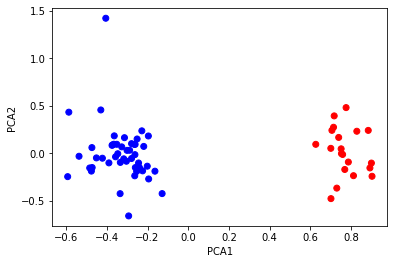

In [362]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(df_median_scaled.drop(['duration_descent','duration_cruise','duration_climb'],axis=1))
plt.scatter(X_pca[:,0],X_pca[:,1], c=['r' if p==1 else 'b' for p in groupes_cah ])
plt.xlabel('PCA1')
plt.ylabel('PCA2')

In [334]:
from sklearn.manifold import TSNE

In [338]:
X_tSNE = TSNE(n_components=2).fit_transform(df_new_scaled.dropna())

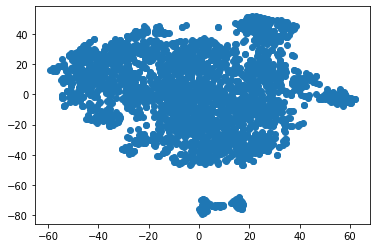

In [339]:
plt.scatter(X_tSNE[:,0],X_tSNE[:,1])

In [322]:
from sklearn.cluster import KMeans

In [365]:
kmeans = KMeans(n_clusters=2).fit(df_median_scaled.drop(['duration_descent','duration_cruise','duration_climb'],axis=1))

In [367]:
kmeans.labels_

array([0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1,
       0])

In [368]:
df_median['group'] = kmeans.labels_

In [369]:
df_median.groupby('group').mean()

,duration_descent,avg_speed_descent,std_speed_descent,avg_vertrate_speed_descent,std_vertrate_speed_descent,max_spd_descent,min_spd_descent,max_vertrate_speed_descent,min_vertrate_speed_descent,duration_cruise,...,std_altitude_cruise,duration_climb,avg_speed_climb,std_speed_climb,avg_vertrate_speed_climb,std_vertrate_speed_climb,max_spd_climb,min_spd_climb,max_vertrate_speed_climb,min_vertrate_speed_climb
group,,,,,,,,,,,,,,,,,,,,,
0,1647.404255,156.630314,54.120786,-6.798398,3.646288,230.852979,67.004043,-0.007021,-15.538404,1944.170213,...,7.463785,1169.521277,193.976174,42.487514,8.982844,4.090034,236.169043,80.459894,19.341277,0.61117
1,1603.750000,157.918089,53.891520,-6.915972,3.751047,230.184750,67.360250,0.000000,-16.055250,1921.725000,...,9.620953,1157.825000,193.458572,42.883995,9.150162,4.151014,236.396500,80.759500,19.508000,0.58000


In [370]:
idg = np.argsort(kmeans.labels_)
df1 = pandas.DataFrame(df_median.index[idg],kmeans.labels_[idg])
df2 = pd.DataFrame.from_dict(airlines_decoder, orient='index')
pd.merge(df1, df2, how = 'left', left_on = 'airline_cat', right_index = True)

,airline_cat,0
0,-1,NaN
0,74,GoAir
0,75,Gulf Air
0,79,Iberia Express
0,80,IndiGo Airlines
...,...,...
1,160,easyJet Europe
1,48,British Airways Shuttle
1,56,China Southern Airlines
1,130,TAP Portugal


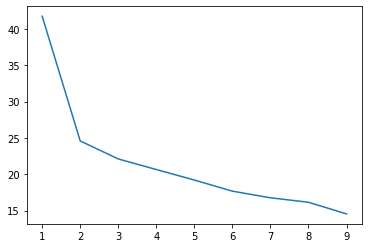

In [351]:
inertias=[]
for k in range(1,10):
    kmeans = KMeans(n_clusters=k).fit(df_median_scaled.drop(['duration_descent','duration_cruise','duration_climb'], axis=1))
    inertias.append(kmeans.inertia_)
plt.plot(range(1,10),inertias)

In [145]:
from scipy.spatial.distance import jensenshannon

In [314]:
def dist_hist(hists1,hists2,distance = jensenshannon):
    nf = hists1.shape[1]

    d = 0
    for i in range(nf):
        d += distance(hists1[:,i],hists2[:,i])**2
    return np.sqrt(d)

In [347]:
class K_Means:
    def __init__(self, k=3, max_iter=300):
        self.k = k
        self.max_iter = max_iter

    def fit(self,data):
        self.centroids = {}
        
        for i in range(self.k):
            self.centroids[i] = np.random.rand(*data[0].shape)
            
        for i in range(self.max_iter):
            self.classifications = {}

            for i in range(self.k):
                self.classifications[i] = []
                
            for featureset in data:
                distances = [dist_hist(featureset,self.centroids[centroid]) for centroid in self.centroids]
                classification = distances.index(min(distances))
                self.classifications[classification].append(featureset)

            prev_centroids = dict(self.centroids)

            for classification in self.classifications:
                if self.classifications[classification] == []:
                    self.fit(data)
                self.centroids[classification] = np.mean(self.classifications[classification],axis=0)
                # self.centroids[classification] = self.centroids[classification]/np.sum(self.centroids[classification],axis=0)

            optimized = True
            
            
            for c in self.centroids:
                original_centroid = prev_centroids[c]
                current_centroid = self.centroids[c]
                if np.array_equal(current_centroid,original_centroid) is False:
                    optimized = False

            if optimized:
                break

    def predict(self,datas):
        classif = []
        for data in datas:
            distances = [dist_hist(data,self.centroids[centroid]) for centroid in self.centroids]
            classif.append(distances.index(min(distances)))
        return classif
    
    def wss(self,datas):
        wss = 0
        for data in datas:
            distances = [dist_hist(data,self.centroids[centroid]) for centroid in self.centroids]
            wss += min(distances)
        return wss

In [157]:
df_new.drop('group',axis=1, inplace=True)

In [158]:
df_new_scaled = pd.DataFrame(data = preprocessing.QuantileTransformer().fit_transform(df_new), columns = columns_remained)
df_new_scaled_cat = pd.merge(df_new_scaled, y, how = 'left', left_index = True, right_on = 'flight_id')

In [159]:
X_hist = []
n=10
airline_cats = df_new_cat['airline_cat'].unique()
for cat in airline_cats:
    cat_df = df_new_scaled_cat[df_new_scaled_cat['airline_cat']==cat]
    cat_df = cat_df.drop(['flight_id','airline_cat'],axis=1)
    hist = np.zeros((n,cat_df.shape[1]))
    i=0
    for col in cat_df:
        hist[:,i] = np.histogram(cat_df[col],bins=10,range=(0,1),density=True)[0]
        i+=1
    X_hist.append(hist)

In [387]:
wss_min = np.inf
lab = []
for i in range(1000):
    k = K_Means(k=2)
    k.fit(X_hist)
    wss = k.wss(X_hist)
    if wss < wss_min:
        wss_min = wss
        lab = k.predict(X_hist)
        
print(wss_min)

34.761692135982365


In [388]:
lab

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1]

1
2
3
4
5
6


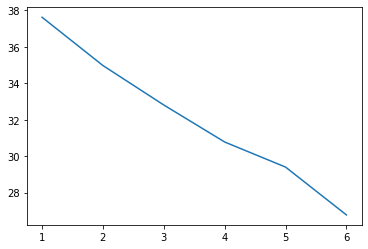

In [353]:
inertias=[]
for k in range(1,7):
    print(k)
    wss = []
    for i in range(100):
        kmeans = K_Means(k=k)
        kmeans.fit(X_hist)
        wss.append(kmeans.wss(X_hist))
    inertias.append(min(wss))
plt.plot(range(1,7),inertias)